# Estimation de Densité avec RealNVP - Tutoriel Complet

Ce notebook présente une implémentation complète de RealNVP (Real-valued Non-Volume Preserving) pour modéliser des distributions 2D complexes.

## Objectifs

1. Comprendre les fondements théoriques des flots normalisants et de RealNVP
2. Implémenter les composants clés (couplage affine, RealNVP)
3. Entraîner des modèles sur différentes distributions 2D (two-moons, cercles, mixtures gaussiennes)
4. Visualiser les transformations et les densités apprises
5. Comparer différentes architectures (profondeur, masques, etc.)

## Structure du Notebook

1. **Introduction théorique** : Formule de changement de variables, log-déterminant du Jacobien
2. **Implémentation** : Couches de couplage affine et modèle RealNVP
3. **Génération de données** : Création des distributions 2D
4. **Entraînement** : Maximum de vraisemblance avec RealNVP
5. **Échantillonnage** : Génération d'échantillons depuis le modèle
6. **Comparaisons** : Impact de la profondeur, nombre de couches, types de masques
7. **Visualisation des densités** : Comparaison densité vraie vs apprise



## 1. Introduction Théorique

### 1.1 Principe des Flots Normalisants

Les flots normalisants sont une classe de modèles génératifs qui apprennent une transformation inversible $f$ entre un espace latent simple (typiquement une gaussienne standard) et un espace observé complexe.

**Conditions requises pour la transformation $f$ :**
1. **Inversible** : $f$ doit être bijective
2. **Jacobien calculable** : Le déterminant du Jacobien doit être facile à calculer

### 1.2 Formule de Changement de Variables

Soit $p_z(z)$ la distribution de base dans l'espace latent et $f: z \mapsto x$ la transformation apprise.

Par la formule de changement de variables, la densité dans l'espace observé est :

$$p_x(x) = p_z(f^{-1}(x)) \cdot \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|$$

En prenant le logarithme :

$$\log p_x(x) = \log p_z(z) + \log \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|$$

où $z = f^{-1}(x)$.

### 1.3 Log-Déterminant du Jacobien

Le terme crucial est le **log-déterminant du Jacobien** :

$$\log \left| \det J_{f^{-1}}(x) \right| = \log \left| \det \frac{\partial f^{-1}(x)}{\partial x} \right|$$

Ce terme mesure le changement de volume dans l'espace lors de la transformation :
- Si $\det > 1$ : la transformation étire l'espace
- Si $\det < 1$ : la transformation compresse l'espace

### 1.4 Couches de Couplage Affine

RealNVP utilise des **couches de couplage affine** qui divisent l'entrée en deux parties :
- **Partie masquée** (dimensions fixes) : utilisée pour paramétrer la transformation
- **Partie transformée** : subit une transformation affine

**Transformation affine :**
$$y = \text{mask} \odot x + (1 - \text{mask}) \odot (x \odot \exp(s) + t)$$

où $s$ (scale) et $t$ (translation) sont calculés par des réseaux de neurones à partir de la partie masquée.

**Avantages :**
- Transformation inversible facilement
- Log-déterminant simple : $\sum (1 - \text{mask}) \odot s$
- Jacobien triangulaire (déterminant = produit des éléments diagonaux)



## 2. Installation et Imports

Commençons par importer tous les modules nécessaires.


In [1]:
import matplotlib.pyplot as plt
import sys
import os
import torch
import numpy as np

torch.set_default_dtype(torch.float64)
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

In [2]:
from models import AffineCoupling, RealNVP_2D, generate_alternating_masks
from data import generate_two_moons, generate_circles, generate_gaussian_mixture
from training import Trainer, negative_log_likelihood
from visualization import (
    plot_transformation, 
    plot_training_curve, 
    plot_samples_comparison,
    compute_density_grid,
    plot_density_heatmap
)

In [3]:
print("Tous les modules ont été importés avec succès!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Tous les modules ont été importés avec succès!
PyTorch version: 2.9.1+cu128
Device disponible: CUDA


## 3. Implémentation des Composants

### 3.1 Couche de Couplage Affine

Examinons d'abord comment fonctionne une couche de couplage affine. Les classes sont déjà implémentées dans `src/models/`, mais regardons leur fonctionnement en détail.


In [4]:

mask = [1.0, 0.0]
hidden_dim = 64

coupling_layer = AffineCoupling(mask, hidden_dim)
coupling_layer.eval()

x = torch.tensor([[1.0, 2.0], [0.5, -1.0]])
print(f"Entrée x: {x}")

y, logdet = coupling_layer(x)
print(f"\nSortie y: {y}")
print(f"Log-déterminant: {logdet}")

x_reconstructed, logdet_inv = coupling_layer.inverse(y)
print(f"\nReconstruction x: {x_reconstructed}")
print(f"Erreur de reconstruction: {torch.abs(x - x_reconstructed).max().item():.2e}")

assert torch.allclose(x, x_reconstructed, atol=1e-5), "La transformation n'est pas inversible!"
print("\nTransformation vérifiée comme inversible!")



Entrée x: tensor([[ 1.0000,  2.0000],
        [ 0.5000, -1.0000]])

Sortie y: tensor([[ 1.0000,  2.1180],
        [ 0.5000, -1.0205]], grad_fn=<DivBackward0>)
Log-déterminant: tensor([0.0481, 0.0446], grad_fn=<AddBackward0>)

Reconstruction x: tensor([[ 1.0000,  2.0000],
        [ 0.5000, -1.0000]], grad_fn=<AddBackward0>)
Erreur de reconstruction: 2.22e-16

Transformation vérifiée comme inversible!


### 3.2 Modèle RealNVP Complet

Le modèle RealNVP compose plusieurs couches de couplage affine. Créons un modèle avec des masques alternés.


In [5]:

masks = generate_alternating_masks(n_layers=4, dim=2)
print("Masques générés:")
for i, mask in enumerate(masks):
    print(f"  Couche {i+1}: {mask}")

hidden_dim = 128
model = RealNVP_2D(masks, hidden_dim)
model.eval()

z = torch.randn(5, 2)
print("\nÉchantillons latents z (avant transformation):")
print(z)

x, logdet = model(z)
print("\nÉchantillons observés x (après transformation):")
print(x)
print(f"\nLog-déterminant total: {logdet}")


device = next(model.parameters()).device
x = x.to(device)
z_reconstructed, logdet_inv = model.inverse(x)
print("\nReconstruction z:")
print(z_reconstructed)
print(f"Erreur de reconstruction: {torch.abs(z.to(device) - z_reconstructed).max().item():.2e}")

assert torch.allclose(z.to(device), z_reconstructed, atol=1e-4), "Le modèle n'est pas inversible!"
print("\nModèle RealNVP vérifié comme inversible!")



Masques générés:
  Couche 1: [1.0, 0.0]
  Couche 2: [0.0, 1.0]
  Couche 3: [1.0, 0.0]
  Couche 4: [0.0, 1.0]

Échantillons latents z (avant transformation):
tensor([[-0.1142,  0.1033],
        [ 0.8093, -0.3930],
        [-0.9301, -0.1099],
        [ 2.2923,  0.0032],
        [ 0.3149,  0.9332]])

Échantillons observés x (après transformation):
tensor([[-0.1907,  0.3274],
        [ 0.8296,  0.0092],
        [-0.9914,  0.1408],
        [ 2.2808,  0.7444],
        [ 0.1045,  1.1870]], grad_fn=<DivBackward0>)

Log-déterminant total: tensor([ 0.0191,  0.0180, -0.0896, -0.1151,  0.0393], grad_fn=<AddBackward0>)

Reconstruction z:
tensor([[-0.1142,  0.1033],
        [ 0.8093, -0.3930],
        [-0.9301, -0.1099],
        [ 2.2923,  0.0032],
        [ 0.3149,  0.9332]], grad_fn=<AddBackward0>)
Erreur de reconstruction: 4.44e-16

Modèle RealNVP vérifié comme inversible!


## 4. Génération des Distributions 2D

Générons et visualisons les trois types de distributions que nous allons modéliser.


In [6]:
N_SAMPLES = 1000

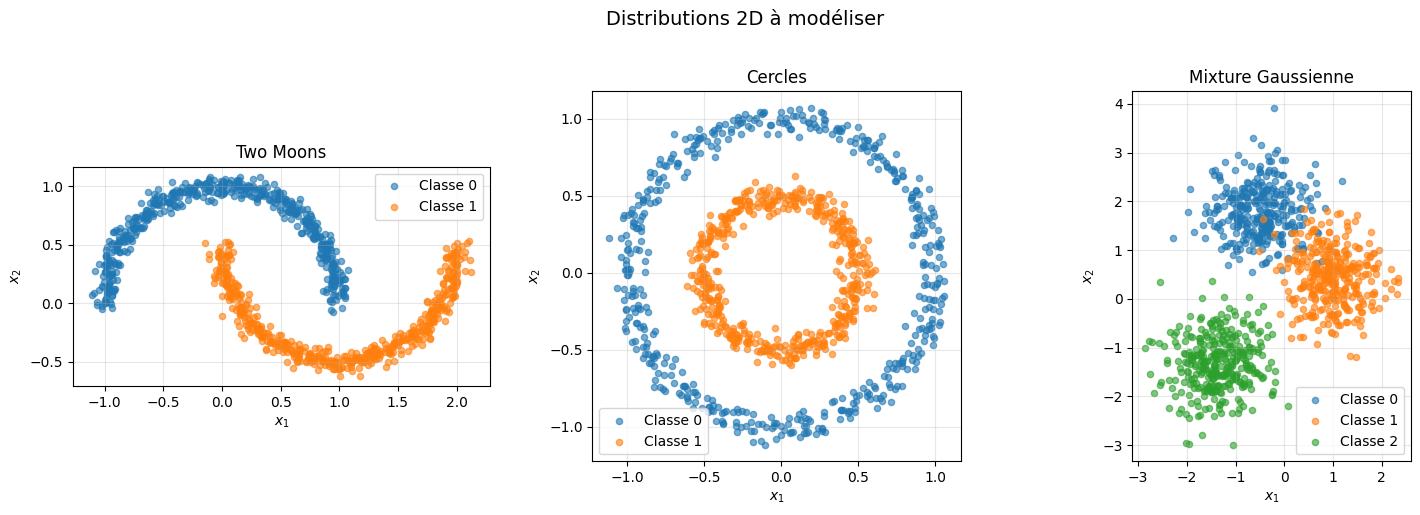

Two Moons: 1000 échantillons
Cercles: 1000 échantillons
Mixture Gaussienne: 1000 échantillons


In [7]:
from visualization import plot_multiple_distributions

X_moons, labels_moons = generate_two_moons(n_samples=N_SAMPLES, noise=0.05)
X_circles, labels_circles = generate_circles(n_samples=N_SAMPLES, noise=0.05)
X_gauss, labels_gauss = generate_gaussian_mixture(n_samples=N_SAMPLES, n_components=3)



distributions = {
    'Two Moons': (X_moons, labels_moons),
    'Cercles': (X_circles, labels_circles),
    'Mixture Gaussienne': (X_gauss, labels_gauss)
}

plot_multiple_distributions(distributions, title="Distributions 2D à modéliser")

print(f"Two Moons: {X_moons.shape[0]} échantillons")
print(f"Cercles: {X_circles.shape[0]} échantillons")
print(f"Mixture Gaussienne: {X_gauss.shape[0]} échantillons")



In [8]:
n_layers = 8
hidden_dim = 128
learning_rate = 0.0001
n_steps = 5000

## 5. Entraînement par Maximum de Vraisemblance

### 5.1 Fonction de Perte (Negative Log-Likelihood)

La fonction de perte est la **negative log-likelihood** basée sur la formule de changement de variables :

$$\text{NLL} = -\log p_x(x) = -\log p_z(z) - \log \left| \det J_{f^{-1}}(x) \right|$$

Pour une gaussienne standard 2D :
$$\text{NLL} = \log(2\pi) + \frac{1}{2}||z||^2 - \log \left| \det J_{f^{-1}}(x) \right|$$

Le terme $- \log \left| \det J_{f^{-1}}(x) \right|$ corrige le changement de volume lors de la transformation.

### 5.2 Entraînement sur Two-Moons

Entraînons un modèle RealNVP sur la distribution two-moons.


Architecture: 8 couches de couplage, hidden_dim=128

Début de l'entraînement sur Two-Moons...
Step 500/5000, Loss: 0.34095, Time: 5.94s
Step 1000/5000, Loss: 0.21633, Time: 11.67s
Step 1500/5000, Loss: 0.17043, Time: 17.37s
Step 2000/5000, Loss: 0.14844, Time: 23.08s
Step 2500/5000, Loss: 0.13343, Time: 28.76s
Step 3000/5000, Loss: 0.11848, Time: 34.49s
Step 3500/5000, Loss: 0.10362, Time: 40.23s
Step 4000/5000, Loss: 0.09206, Time: 45.95s
Step 4500/5000, Loss: 0.07826, Time: 51.66s
Step 5000/5000, Loss: 0.06779, Time: 57.41s

Entraînement terminé en 57.41s
Perte finale: 0.06779


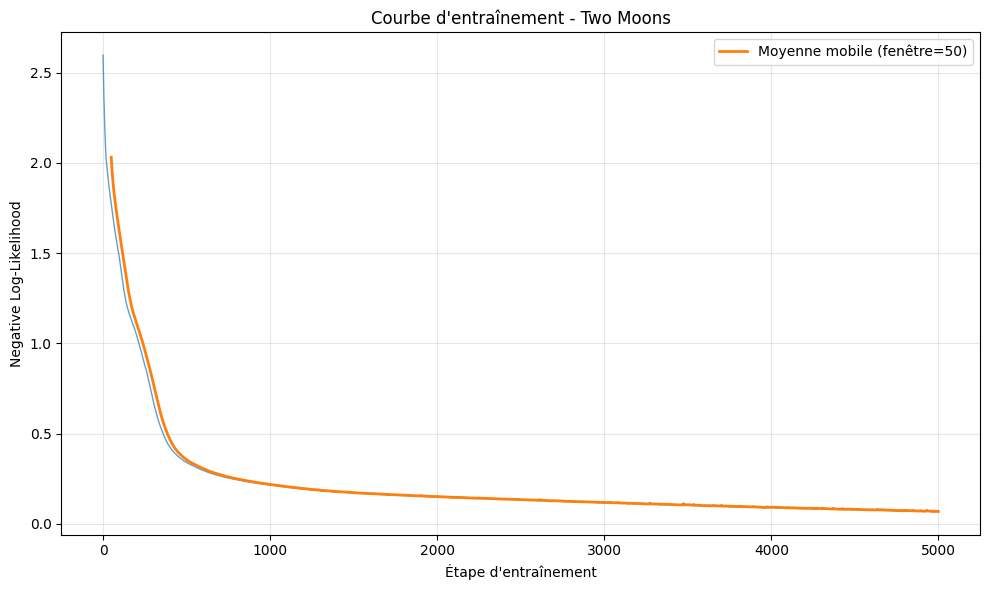

In [9]:
masks = generate_alternating_masks(n_layers, dim=2)
print(f"Architecture: {n_layers} couches de couplage, hidden_dim={hidden_dim}")

model_moons = RealNVP_2D(masks, hidden_dim)

trainer_moons = Trainer(model_moons, lr=learning_rate, device='auto')

def data_generator_moons():
    X, _ = generate_two_moons(n_samples=512, noise=0.05)
    return torch.tensor(X, dtype=torch.float64)

print("\nDébut de l'entraînement sur Two-Moons...")
loss_history_moons = trainer_moons.train(
    data_generator=data_generator_moons,
    n_steps=n_steps,
    print_every=500,
    verbose=True
)

plot_training_curve(loss_history_moons, title="Courbe d'entraînement - Two Moons")



### 5.3 Visualisation de la Transformation x → z

Vérifions que le modèle transforme correctement les données two-moons vers une distribution normale standard.


Figure sauvegardée dans ../output/moons_transformation.png


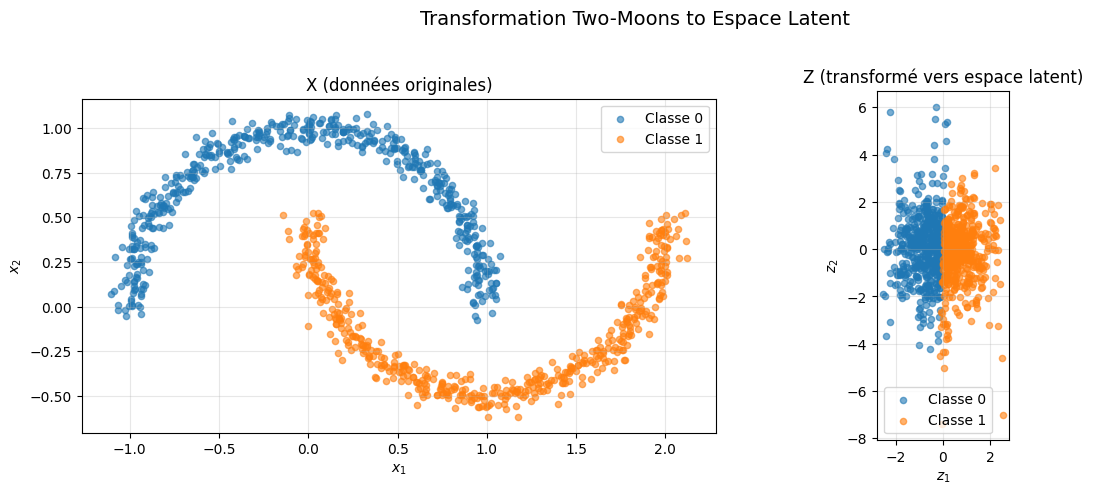

Transformation visualisée!
Moyenne de z: [-0.02658478 -0.02738656]
Écart-type de z: [0.98394494 1.42090965]


In [10]:

X_test, labels_test = generate_two_moons(n_samples=N_SAMPLES, noise=0.05)
X_test_tensor = torch.tensor(X_test, dtype=torch.float64)

device = next(model_moons.parameters()).device
X_test_tensor = X_test_tensor.to(device)

model_moons.eval()
with torch.no_grad():
    z_test, _ = model_moons.inverse(X_test_tensor)
z_test = z_test.cpu().numpy()

plot_transformation(
    X_test, 
    z_test, 
    labels=labels_test,
    title="Transformation Two-Moons to Espace Latent",
    save_path="../output/moons_transformation.png"
)

print("Transformation visualisée!")
print(f"Moyenne de z: {z_test.mean(axis=0)}")
print(f"Écart-type de z: {z_test.std(axis=0)}")



## 6. Échantillonnage

Générons maintenant des échantillons depuis le modèle entraîné en transformant des échantillons de la distribution normale standard.


Figure sauvegardée dans ../output/moons_samples_comparison.png


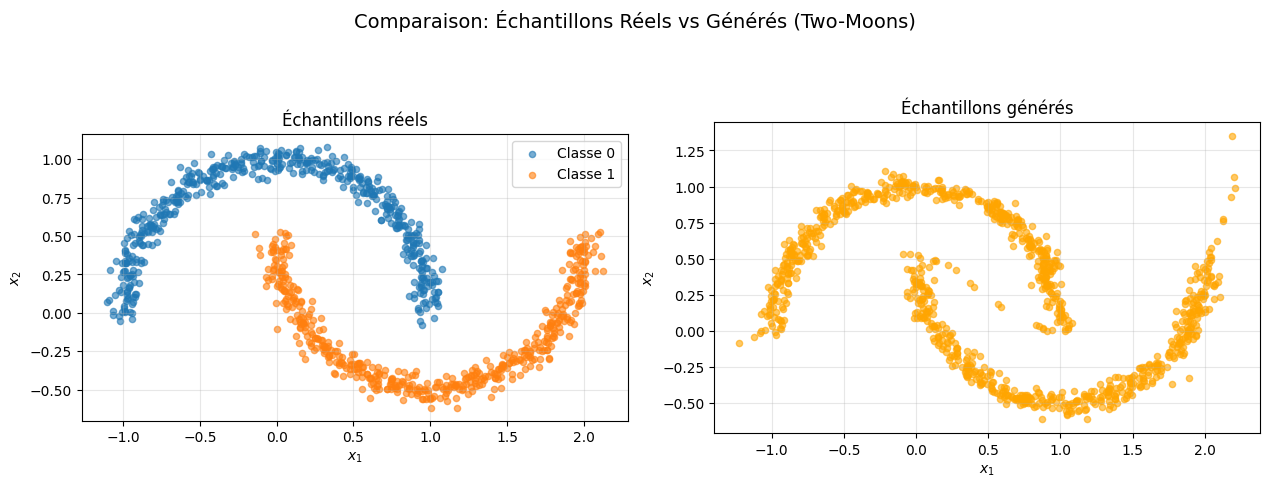

Échantillons générés et visualisés!


In [11]:
generated_samples = trainer_moons.sample(n_samples=N_SAMPLES)

real_samples, real_labels = generate_two_moons(n_samples=N_SAMPLES, noise=0.05)

plot_samples_comparison(
    real_samples=real_samples,
    generated_samples=generated_samples.numpy(),
    labels_real=real_labels,
    title="Comparaison: Échantillons Réels vs Générés (Two-Moons)",
    save_path="../output/moons_samples_comparison.png"
)

print("Échantillons générés et visualisés!")



## 7. Entraînement sur les Autres Distributions

### 7.1 Cercles


Entraînement sur Cercles...
Step 500/5000, Loss: 0.91696, Time: 5.73s
Step 1000/5000, Loss: 0.74945, Time: 11.44s
Step 1500/5000, Loss: 0.66975, Time: 17.12s
Step 2000/5000, Loss: 0.62416, Time: 22.80s
Step 2500/5000, Loss: 0.59069, Time: 28.53s
Step 3000/5000, Loss: 0.57393, Time: 34.26s
Step 3500/5000, Loss: 0.60457, Time: 40.00s
Step 4000/5000, Loss: 0.55681, Time: 45.68s
Step 4500/5000, Loss: 0.56945, Time: 51.36s
Step 5000/5000, Loss: 0.49769, Time: 57.06s

Entraînement terminé en 57.06s
Perte finale: 0.49769


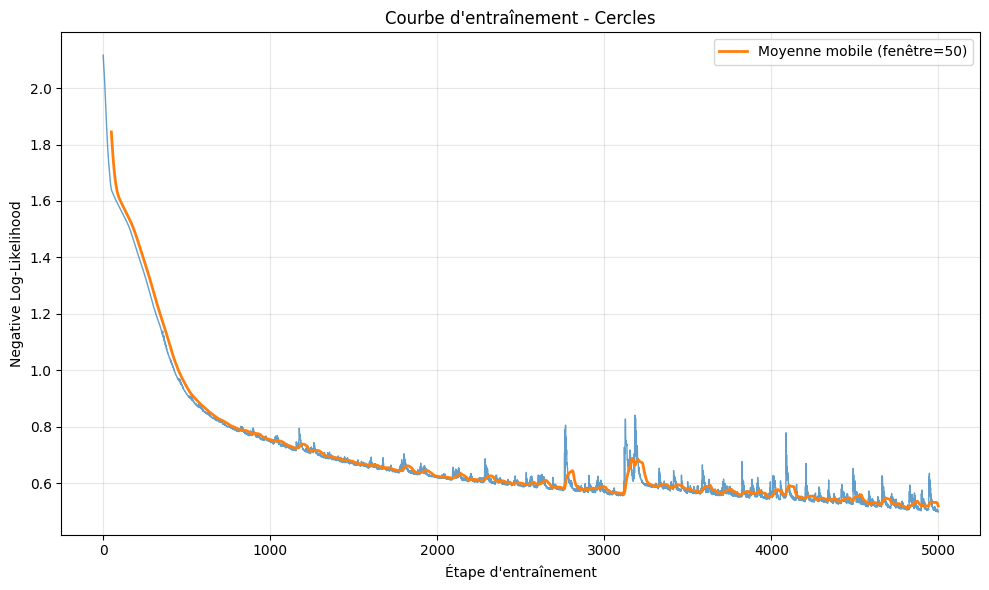

Figure sauvegardée dans ../output/circles_samples_comparison.png


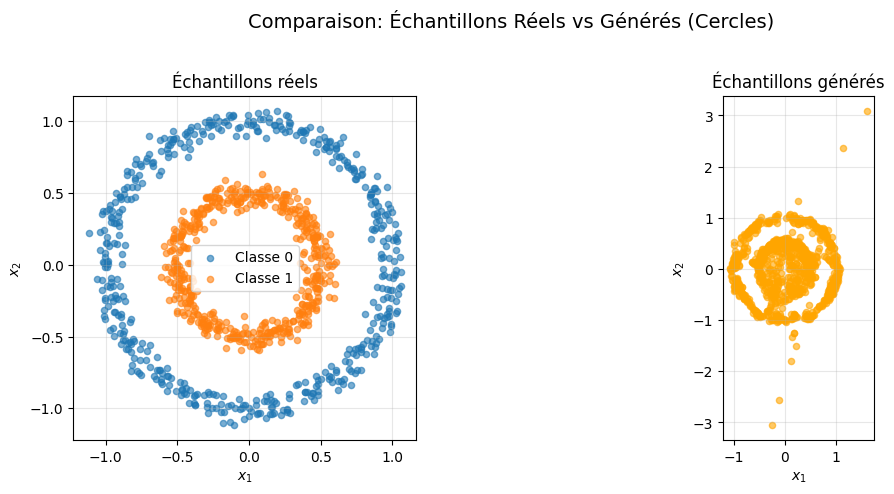

In [13]:

model_circles = RealNVP_2D(masks, hidden_dim)
trainer_circles = Trainer(model_circles, lr=learning_rate, device='auto')


def data_generator_circles():
    X, _ = generate_circles(n_samples=512, noise=0.05)
    return torch.tensor(X, dtype=torch.float64)


print("Entraînement sur Cercles...")
loss_history_circles = trainer_circles.train(
    data_generator=data_generator_circles,
    n_steps=n_steps,
    print_every=500,
    verbose=True
)

plot_training_curve(loss_history_circles, title="Courbe d'entraînement - Cercles")


real_circles, labels_circles = generate_circles(n_samples=N_SAMPLES, noise=0.05)
generated_circles = trainer_circles.sample(n_samples=N_SAMPLES)

plot_samples_comparison(
    real_samples=real_circles,
    generated_samples=generated_circles.numpy(),
    labels_real=labels_circles,
    title="Comparaison: Échantillons Réels vs Générés (Cercles)",
    save_path="../output/circles_samples_comparison.png"
)



### 7.2 Mixture Gaussienne


Entraînement sur Mixture Gaussienne...
Step 500/5000, Loss: 2.56602, Time: 5.69s
Step 1000/5000, Loss: 2.47850, Time: 11.34s
Step 1500/5000, Loss: 2.43690, Time: 16.99s
Step 2000/5000, Loss: 2.40293, Time: 22.67s
Step 2500/5000, Loss: 2.38590, Time: 28.34s
Step 3000/5000, Loss: 2.33945, Time: 34.02s
Step 3500/5000, Loss: 2.29801, Time: 39.68s
Step 4000/5000, Loss: 2.25504, Time: 45.34s
Step 4500/5000, Loss: 2.23231, Time: 51.00s
Step 5000/5000, Loss: 2.20732, Time: 56.66s

Entraînement terminé en 56.66s
Perte finale: 2.20732


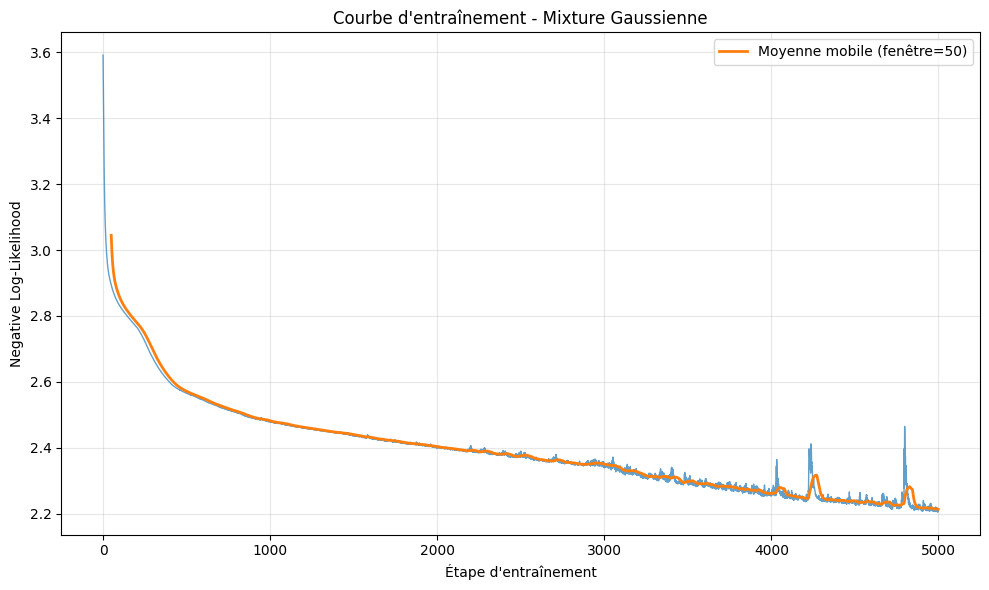

Figure sauvegardée dans ../output/gauss_samples_comparison.png


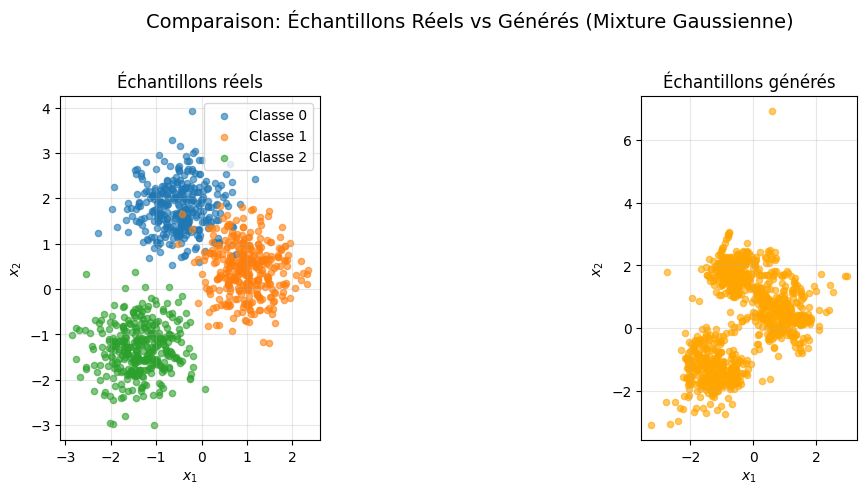

In [14]:

model_gauss = RealNVP_2D(masks, hidden_dim)
trainer_gauss = Trainer(model_gauss, lr=learning_rate, device='auto')

def data_generator_gauss():
    X, _ = generate_gaussian_mixture(n_samples=512, n_components=3)
    return torch.tensor(X, dtype=torch.float64)

print("Entraînement sur Mixture Gaussienne...")
loss_history_gauss = trainer_gauss.train(
    data_generator=data_generator_gauss,
    n_steps=n_steps,
    print_every=500,
    verbose=True
)


plot_training_curve(loss_history_gauss, title="Courbe d'entraînement - Mixture Gaussienne")


real_gauss, labels_gauss = generate_gaussian_mixture(n_samples=N_SAMPLES, n_components=3)
generated_gauss = trainer_gauss.sample(n_samples=N_SAMPLES)

plot_samples_comparison(
    real_samples=real_gauss,
    generated_samples=generated_gauss.numpy(),
    labels_real=labels_gauss,
    title="Comparaison: Échantillons Réels vs Générés (Mixture Gaussienne)",
    save_path="../output/gauss_samples_comparison.png"
)



## 8. Comparaisons Systématiques

### 8.1 Comparaison par Profondeur (Nombre de Couches)

Comparons l'impact du nombre de couches de couplage sur les performances.


In [15]:
depths = [2, 4, 6, 8, 10]
n_steps_comparison = 10000


Test avec 2 couches
Perte finale (NLL): 2.95968

Test avec 4 couches
Perte finale (NLL): 3.25888

Test avec 6 couches
Perte finale (NLL): 2.19295

Test avec 8 couches
Perte finale (NLL): 0.98193

Test avec 10 couches
Perte finale (NLL): 0.70872


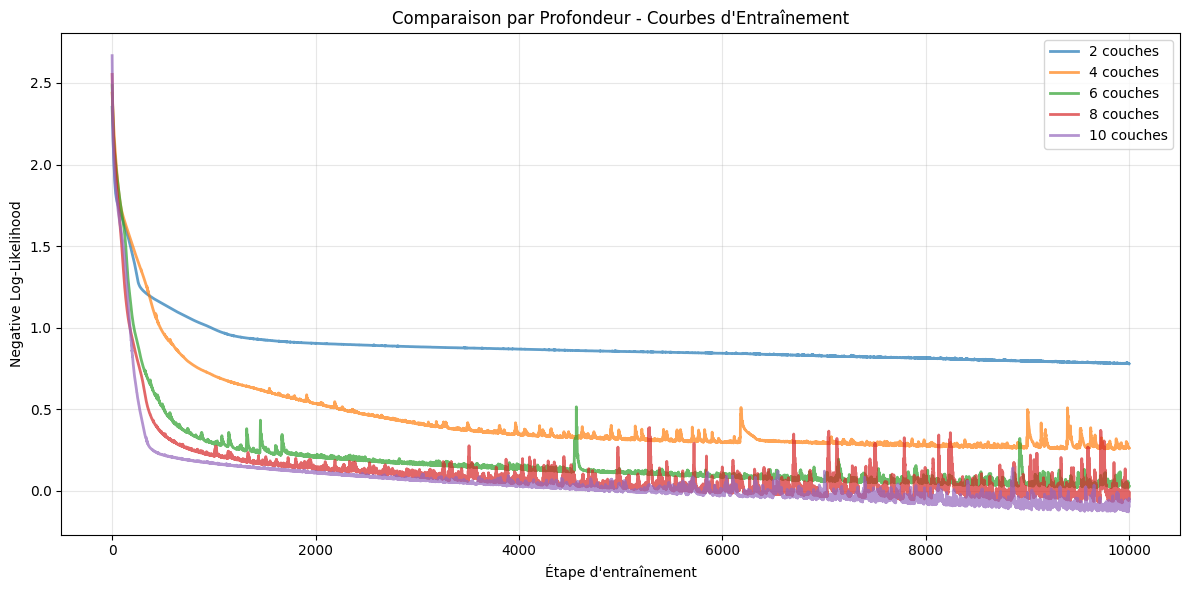


RÉSUMÉ - Comparaison par Profondeur
Profondeur   NLL Final       Amélioration   
------------------------------------------------------------
2            2.95968               0.00%
4            3.25888             -10.11%
6            2.19295              25.91%
8            0.98193              66.82%
10           0.70872              76.05%


In [16]:
results_depth = {}

for depth in depths:
    print(f"\n{'='*60}")
    print(f"Test avec {depth} couches")
    print(f"{'='*60}")
    
    masks_depth = generate_alternating_masks(depth, dim=2)
    model_depth = RealNVP_2D(masks_depth, hidden_dim)
    trainer_depth = Trainer(model_depth, lr=learning_rate, device='auto')
    
    loss_history = trainer_depth.train(
        data_generator=data_generator_moons,
        n_steps=n_steps_comparison,
        print_every=1000,
        verbose=False
    )
    
    X_test, _ = generate_two_moons(n_samples=N_SAMPLES, noise=0.05)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
    metrics = trainer_depth.evaluate(X_test_tensor)
    
    results_depth[depth] = {
        'loss_history': loss_history,
        'final_nll': metrics['nll'],
        'model': model_depth,
        'trainer': trainer_depth
    }
    
    print(f"Perte finale (NLL): {metrics['nll']:.5f}")

plt.figure(figsize=(12, 6))
for depth in depths:
    plt.plot(results_depth[depth]['loss_history'], 
            label=f'{depth} couches', alpha=0.7, linewidth=2)

plt.xlabel("Étape d'entraînement")
plt.ylabel("Negative Log-Likelihood")
plt.title("Comparaison par Profondeur - Courbes d'Entraînement")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../output/comparison_depth_training.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("RÉSUMÉ - Comparaison par Profondeur")
print("="*60)
print(f"{'Profondeur':<12} {'NLL Final':<15} {'Amélioration':<15}")
print("-"*60)
baseline_nll = results_depth[depths[0]]['final_nll']
for depth in depths:
    nll = results_depth[depth]['final_nll']
    improvement = ((baseline_nll - nll) / baseline_nll) * 100
    print(f"{depth:<12} {nll:<15.5f} {improvement:>10.2f}%")
print("="*60)



### 8.2 Comparaison par Type de Masques

Comparons l'impact de différents patterns de masques sur les performances.



Test avec masques: Alternés
Premiers masques:
  Couche 1: [1.0, 0.0]
  Couche 2: [0.0, 1.0]
  Couche 3: [1.0, 0.0]
  Couche 4: [0.0, 1.0]
Perte finale (NLL): 145.10698

Test avec masques: Checkerboard
Premiers masques:
  Couche 1: [1.0, 0.0]
  Couche 2: [0.0, 1.0]
  Couche 3: [1.0, 0.0]
  Couche 4: [0.0, 1.0]
Perte finale (NLL): 1.77331

Test avec masques: Aléatoires
Premiers masques:
  Couche 1: [1.0, 0.0]
  Couche 2: [1.0, 0.0]
  Couche 3: [0.0, 1.0]
  Couche 4: [1.0, 0.0]
Perte finale (NLL): 1.13504


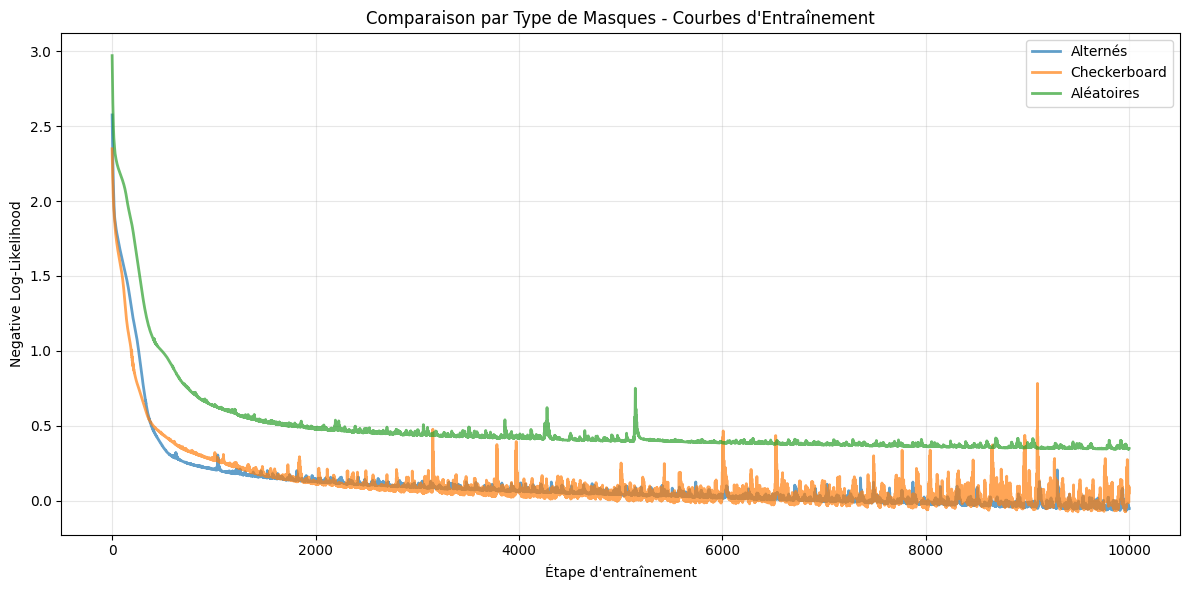


RÉSUMÉ - Comparaison par Type de Masques
Type de Masque       NLL Final      
------------------------------------------------------------
Alternés             145.10698      
Checkerboard         1.77331        
Aléatoires           1.13504        


In [17]:
from models import generate_checkerboard_masks, generate_random_masks

mask_types = {
    'Alternés': generate_alternating_masks(8, dim=2),
    'Checkerboard': generate_checkerboard_masks(8, dim=2),
    'Aléatoires': generate_random_masks(8, dim=2, seed=42)
}

results_masks = {}

for mask_name, masks_mask in mask_types.items():
    print(f"\n{'='*60}")
    print(f"Test avec masques: {mask_name}")
    print(f"{'='*60}")
    
    print("Premiers masques:")
    for i, m in enumerate(masks_mask[:4]):
        print(f"  Couche {i+1}: {m}")
    
    model_mask = RealNVP_2D(masks_mask, hidden_dim)
    trainer_mask = Trainer(model_mask, lr=learning_rate, device='auto')
    
    loss_history = trainer_mask.train(
        data_generator=data_generator_moons,
        n_steps=n_steps_comparison,
        print_every=1000,
        verbose=False
    )
    
    X_test, _ = generate_two_moons(n_samples=N_SAMPLES, noise=0.05)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
    metrics = trainer_mask.evaluate(X_test_tensor)
    
    results_masks[mask_name] = {
        'loss_history': loss_history,
        'final_nll': metrics['nll'],
        'masks': masks_mask
    }
    
    print(f"Perte finale (NLL): {metrics['nll']:.5f}")

plt.figure(figsize=(12, 6))
for mask_name in mask_types.keys():
    plt.plot(results_masks[mask_name]['loss_history'], 
            label=mask_name, alpha=0.7, linewidth=2)

plt.xlabel("Étape d'entraînement")
plt.ylabel("Negative Log-Likelihood")
plt.title("Comparaison par Type de Masques - Courbes d'Entraînement")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../output/comparison_masks_training.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("RÉSUMÉ - Comparaison par Type de Masques")
print("="*60)
print(f"{'Type de Masque':<20} {'NLL Final':<15}")
print("-"*60)
for mask_name in mask_types.keys():
    nll = results_masks[mask_name]['final_nll']
    print(f"{mask_name:<20} {nll:<15.5f}")
print("="*60)



Figure sauvegardée dans ../output/moons_density.png


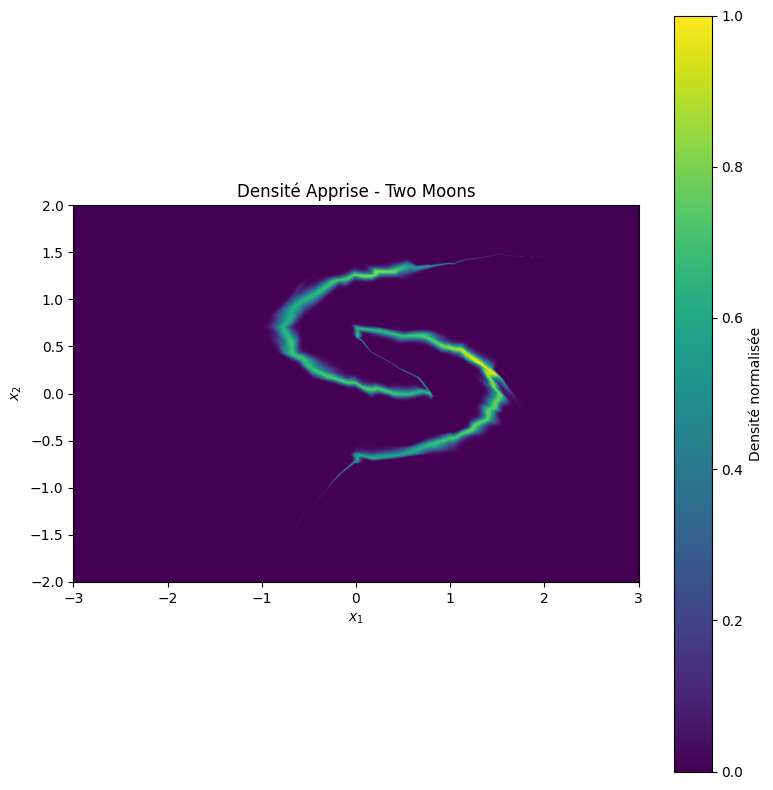

In [18]:

X_grid, Y_grid, density_moons = compute_density_grid(
    model_moons, 
    xlim=(-3, 3), 
    ylim=(-2, 2), 
    resolution=1000
)


plot_density_heatmap(
    X_grid, 
    Y_grid, 
    density_moons,
    title="Densité Apprise - Two Moons",
    save_path="../output/moons_density.png"
)


## 10. Conclusion

Ce notebook a présenté une implémentation complète de RealNVP pour modéliser des distributions 2D complexes. 

### Points Clés à Retenir :

1. **Formule de changement de variables** : Permet de calculer la densité dans l'espace observé à partir de la densité dans l'espace latent
2. **Log-déterminant du Jacobien** : Terme crucial qui corrige le changement de volume lors de la transformation
3. **Couches de couplage affine** : Permettent de créer des transformations inversibles avec calcul efficace du Jacobien
4. **Composition de transformations** : Plusieurs couches permettent d'apprendre des distributions complexes
5. **Impact de l'architecture** : La profondeur et le type de masques influencent les performances

### Résultats Observés :

- Les modèles RealNVP réussissent à capturer les structures complexes des distributions 2D
- Plus de couches améliorent généralement les performances mais avec un coût computationnel
- Les masques alternés sont généralement efficaces pour les distributions 2D

### Extensions Possibles :

- Appliquer à des dimensions plus élevées
- Tester d'autres types de couplages (additifs, etc.)
- Utiliser des techniques de permutation plus sophistiquées (GLOW)
- Entraîner sur des données réelles de plus haute dimension
